
<h1>Transformer for Text Summarization with the BBC  Summary Dataset</h1>



<h2>Install Dependencies</h2>

In [ ]:
!pip3 install torch torchvision

<h2>Import Necessary Libraries</h2>

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
import random
from tqdm import tqdm
import math

<h2>Instantiate the Tokenizer using Spacy</h2>

In [ ]:
# Tokenizer using spacy
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

<h2>Define a custom function to create a dataframe from the text files</h2>


In [ ]:
# Add data from files into dataframe for easier access
def create_dataframe(source_text_path,target_text_path):
    txt_files_source = [file for file in os.listdir(source_text_path) if file.endswith('.txt')]
    txt_files_target = [file for file in os.listdir(target_text_path) if file.endswith('.txt')]
    df = pd.DataFrame(columns=['headlines','text'])
    for source,target in zip(txt_files_source,txt_files_target):
        assert source==target
        source_file_path = os.path.join(source_text_path, source)
        target_file_path = os.path.join(target_text_path, target)
        # Read the content of the file
        with open(source_file_path,'r',encoding='latin-1') as file:
            source_text = file.read()
        with open(target_file_path,'r',encoding='latin-1') as file:
            target_text = file.read()
        df.loc[len(df.index)] = [source_text,target_text]
    return df

<h2>Define functions to save the weights, load them and check for accuracy</h2>


In [ ]:
# Check accuracy function
def check_accuracy(output,labels):
    _ , predpos = output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100

# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(checkpoint,model,optim):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

<h2>Create dataframes for all the folders with Text Paragraphs and Summaries in our dataset</h2>

In [ ]:
import os
import pandas as pd

def create_dataframe(source_text_path, target_text_path):
    """
    Add data from files into dataframe for easier access.
    Assumes files in both directories are ordered and correspond by index.
    """
    txt_files_source = [file for file in os.listdir(source_text_path) if file.endswith('.txt')]
    txt_files_target = [file for file in os.listdir(target_text_path) if file.endswith('.txt')]

    # Instead of asserting equality, ensure both lists have the same length
    assert len(txt_files_source) == len(txt_files_target), "Mismatched number of files in source and target directories."

    df = pd.DataFrame(columns=['headlines', 'text'])
    for i in range(len(txt_files_source)):
        source_file_path = os.path.join(source_text_path, txt_files_source[i])
        target_file_path = os.path.join(target_text_path, txt_files_target[i])

        # Read the content of the files
        with open(source_file_path, 'r', encoding='latin-1') as file:
            source_text = file.read()
        with open(target_file_path, 'r', encoding='latin-1') as file:
            target_text = file.read()

        df.loc[len(df.index)] = [source_text, target_text]

    return df

In [ ]:
df1 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/business","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/business")
df2 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/entertainment","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/entertainment")
df3 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/politics","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics")
df4 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/sport","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/sport")
df5 = create_dataframe("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles/tech","/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/tech")

<h2>Combine all the dataframes into one dataframe</h2>


In [ ]:
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)


<h2>Split the data into train and test set</h2>


In [ ]:
# Split into train and test sets
df = df.rename(columns = {"headlines":"source_text","text":"summary_text"})
X,Y = df["source_text"],df["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

<h2>Add contraction mapping</h2>


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


stop_words = set(stopwords.words('english'))

<h2>Clean the text for punctuations and remove stop words</h2>


In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = newString.replace('"', "'")
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    return " ".join(tokens)

<h2>Tokenize and lower case using lower case the tokens for training and test set</h2>


In [ ]:
# Tokenize and lowercase text using spacy
train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

<h2>Add START and END tokens to the Summary</h2>


In [ ]:
# Add START AND END tokens to summary
train_df['source_text'] = train_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

test_df['source_text'] = test_df['source_text'].apply(lambda x : ['_START_']+ x + ['_END_'])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x : ['_START_']+ x + ['_END_'])

In [ ]:
train_df.head()


,source_text,summary_text
1490,"[_START_, ferguson, fears, milan, cutting, edg...","[_START_, loss, could, worse, quality, bring, ..."
2001,"[_START_, ask, jeeves, joins, web, log, market...","[_START_, jim, lanzone, vice, president, searc..."
1572,"[_START_, safin, cool, wimbledon, newly, crown...","[_START_, expect, sampras, favourite, pressure..."
1840,"[_START_, mobiles, rack, years, use, mobile, p...","[_START_, cellnet, vodafone, mobile, phone, op..."
610,"[_START_, eminem, secret, gig, venue, revealed...","[_START_, fourth, album, rap, star, sale, two,..."


<h2>Build vocabularies - each word has an index, note : words sorted in ascending order</h2>


In [ ]:
# Build vocabularies - each word has an index, note : words sorted in ascending order
all_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}

<h2>Switch to Kaggle GPU for faster training</h2>


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cuda


In [ ]:
temp = list(sorted(source_vocab.items()))
for word, idx in temp[-5:]:
    print(word,idx)

zuluaga 27632
zurich 27633
zutons 27634
zvonareva 27635
zvyagintsev 27636


<h2>Converting words to their corresponding vocabulary indices.</h2>


In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

<h2>Create custom datasets</h2>

In [ ]:
# Create custom datasets
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['summary_text'].tolist(),source_vocab, target_vocab)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['summary_text'].tolist(),source_vocab, target_vocab)

<h2>Get Maximum Sequence Length</h2>

In [ ]:
def get_max_seqlen():
    max_length = 0
    for index, row in train_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    for index, row in test_df.iterrows():
        # Calculate the length of the current row
        row_length = len(row['source_text'])
        # Update the maximum length if the current row length is greater
        max_length = max(max_length, row_length)
    print("Max length in dataset ",max_length)
    return max_length

In [ ]:
print(get_max_seqlen())

Max length in dataset  1986
1986


<h2>Vocabulary Coverage Analysis Visualization</h2>

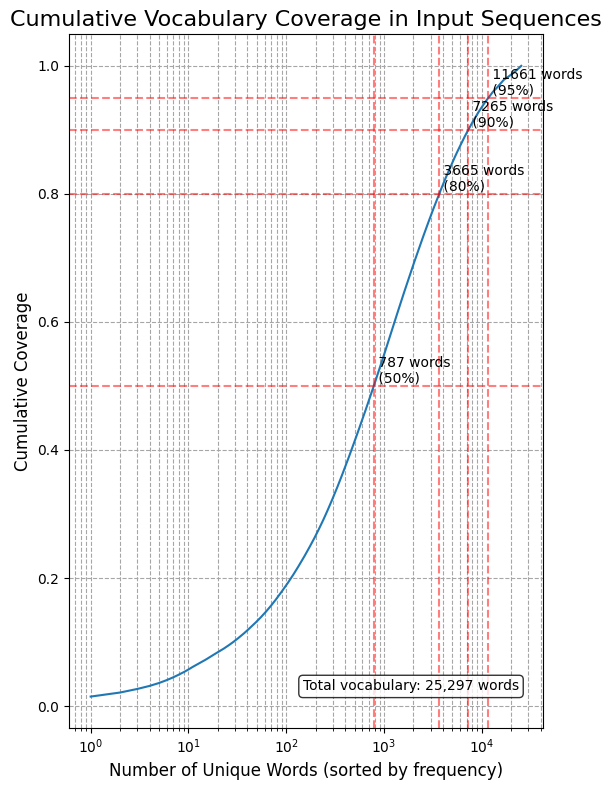

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_vocab_coverage(texts, title="Cumulative Vocabulary Coverage"):
    all_words = [word for text in texts for word in text]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    cumulative_coverage = np.cumsum([count for word, count in sorted_words]) / len(all_words)

    plt.figure(figsize=(6, 8))
    plt.plot(range(1, len(cumulative_coverage) + 1), cumulative_coverage)

    plt.title(title, fontsize=16)
    plt.xlabel('Number of Unique Words (sorted by frequency)', fontsize=12)
    plt.ylabel('Cumulative Coverage', fontsize=12)
    plt.xscale('log')
    plt.grid(True, which="both", ls="--", c='0.65')

    # Add reference lines
    coverage_levels = [0.5, 0.8, 0.9, 0.95]
    for level in coverage_levels:
        words_needed = np.argmax(cumulative_coverage >= level) + 1
        plt.axhline(y=level, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=words_needed, color='r', linestyle='--', alpha=0.5)
        plt.text(words_needed, level, f' {words_needed} words\n ({level:.0%})',
                 verticalalignment='bottom', horizontalalignment='left')

    # Add annotation for total vocabulary size
    total_vocab = len(word_counts)
    plt.text(0.95, 0.05, f'Total vocabulary: {total_vocab:,} words',
             transform=plt.gca().transAxes, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Usage
plot_vocab_coverage(train_df['source_text'], title="Cumulative Vocabulary Coverage in Input Sequences")

<h2>Distribution of Sequence Lengths</h2>

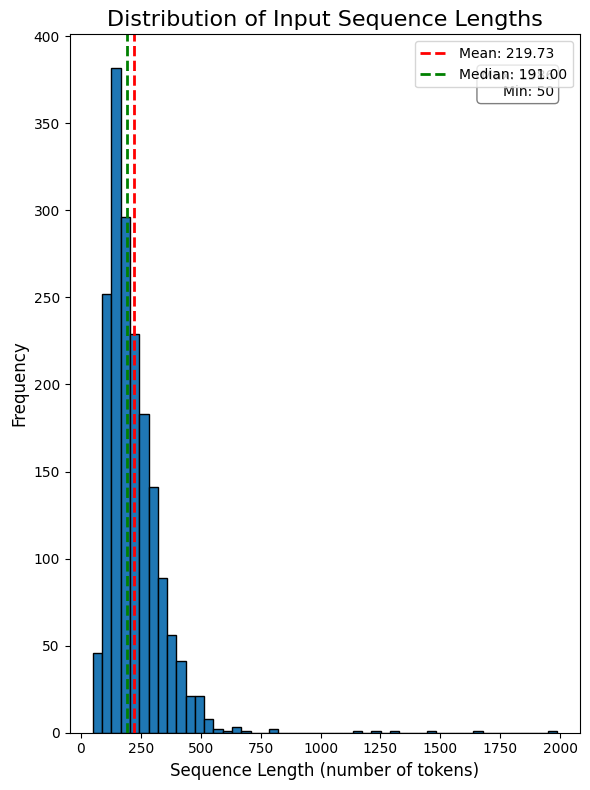

In [ ]:
def plot_sequence_lengths(data, title="Distribution of Sequence Lengths"):
    # Check if the elements are lists or strings
    if isinstance(data[0], list):
        lengths = [len(seq) for seq in data]
    else:
        lengths = [len(seq.split()) for seq in data]  # For string sequences

    plt.figure(figsize=(6, 8))
    n, bins, patches = plt.hist(lengths, bins=50, edgecolor='black')

    # Add mean and median lines
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)
    plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
    plt.axvline(median_length, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_length:.2f}')

    plt.title(title, fontsize=16)
    plt.xlabel('Sequence Length (number of tokens)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()

    # Add text with statistics
    max_length = max(lengths)
    min_length = min(lengths)
    plt.text(0.95, 0.95, f'Max: {max_length}\nMin: {min_length}',
             transform=plt.gca().transAxes, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Usage
plot_sequence_lengths(train_df['source_text'], title="Distribution of Input Sequence Lengths")

<h2>Define collate function for DataLoader</h2>


In [ ]:
# Define collate function for DataLoader
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

<h2>Implement Multi-Head Attention</h2>

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention,self).__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dim_perhead = embedding_dim // num_heads

        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.W_o = nn.Linear(embedding_dim, embedding_dim)

    def scaled_dot_product_attention(self,Q,K,V,mask=None):
        # Q,K,V Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]

        K = K.transpose(-2,-1) # K = K.permute(0,1,3,2) also works
        # K Shape(after permute) : [Batch_Size X Num_Heads X Dim Per Head X Seq_len]
        attn_scores = torch.matmul(Q,K) / math.sqrt(self.dim_perhead)
        # attn_scores Shape : [Batch_Size X Num_Heads X Seq_len X Seq_len]
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # attn_probs Shape : [Batch_Size X Num_Heads X Seq_len X Seq_len]
        output = torch.matmul(attn_probs, V)
        # output Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        return output

    def split_heads(self, x):
        # X shape : [Batch_Size X Seq_len X Embedding Dim]
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length,self.num_heads,self.dim_perhead)
        # X shape : [Batch_Size X Seq_len X Num_Heads X Dim Per Head]
        x = x.transpose(1,2)
        # X shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        return x

    def combine_heads(self, x):
        # x Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        batch_size, _, seq_length, dim_perhead = x.size()
        x = x.transpose(1,2).contiguous()
        # x Shape : [Batch_Size X Seq_len X Num_Heads X Dim Per Head]
        x = x.view(batch_size, seq_length,self.embedding_dim)
        # x Shape : [Batch_Size X Seq_len X Embedding Dim]
        return x

    def forward(self, Q, K, V, mask=None):
        # Q,K,V Shape : [Batch_Size X Seq_len X Embedding Dim]
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        # Q,K,V Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        # attn_output Shape : [Batch_Size X Num_Heads X Seq_len X Dim Per Head]
        output = self.W_o(self.combine_heads(attn_output))
        # output Shape :  # x Shape : [Batch_Size X Seq_len X Embedding Dim]
        return output

<h2>Implement Position Wise Feed Forward Network and Add positional encoding</h2>

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # shape does not change here
        return self.fc2(F.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length,dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model,2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe',pe.unsqueeze(0))

    def forward(self, x):
        # shape does not change here, adding positional encoding information
        return x + self.pe[:, :x.size(1)]

<h2>Define Encoder and Decoder for Transformer</h2>

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x shape [Batch_Size X Seq_len X Embedding Dim]
        attn_output = self.self_attn(x, x, x,mask)
        # attn_output shape [Batch_Size X Seq_len X Embedding Dim]
        x = self.norm1(x + self.dropout(attn_output))
        # x shape [Batch_Size X Seq_len X Embedding Dim]
        ff_output = self.feed_forward(x)
        # ff_output shape [Batch_Size X Seq_len X Embedding Dim]
        x = self.norm2(x + self.dropout(ff_output))
        # x shape [Batch_Size X Seq_len X Embedding Dim]
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x,tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x,enc_output,enc_output,src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

<h2>Implement the Transformer</h2>

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length,device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

<h2>Initialize the parameters and call the model</h2>


In [ ]:
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = get_max_seqlen()
dropout = 0.1
num_workers = 2
num_epochs = 20

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
print(model)

Max length in dataset  1986
Transformer(
  (encoder_embedding): Embedding(27637, 512)
  (decoder_embedding): Embedding(27637, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderL

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

86616565


<h2>Specify optimizer and loss function</h2>


In [ ]:
# Specify optimizer and loss function
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

<h2>Create dataloaders</h2>


In [ ]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

In [ ]:
source_dummy,target_dummy = next(iter(train_loader))


<h2>Data Batch Extraction Example</h2>


In [ ]:
print(source_dummy.shape,target_dummy.shape)


torch.Size([4, 281]) torch.Size([4, 147])


In [ ]:
print(source_dummy[1])


tensor([    1, 12930, 10205,  7693,   244, 18439, 12927, 19019, 15783, 22476,
         2337, 26069, 18450,   558, 13536,  5549, 23282,  7700, 24884, 16709,
        21064, 18931,   244, 18439,  6672, 12930, 15448, 12336, 25211, 25914,
        14027, 16205,  2337,  8615, 24299, 20120,   558,  2823, 20525,  6672,
        23144,  4879, 22742,  9265,   759,  9452,  1936, 13996, 22717, 17600,
        14101, 24291, 19019, 15783, 21604, 23428, 15448, 10389, 10512,   198,
        25763, 19587, 14891, 11022, 12930,  4867,  8397, 16465, 14029,  2969,
         7386,  5549,  3095, 24360,   914, 21530, 11455,  9259, 23337, 23566,
         6765,  8623, 10934,  6672, 22742, 15444, 22580,  3402, 20643, 21530,
        12930,  5444, 13881,  9154, 16933, 22743,  4842, 17107, 20322,  2169,
         2437,  8715, 11097, 27338,   159, 21247, 13918,  9260, 24938,  1936,
        13996, 14881,  6765,  8794,  4845,  6849, 22030, 16626,  3402,  7944,
         6161, 22567, 10934, 12930,  8196, 23179, 10512, 21535, 

In [ ]:
print(torch.min(target_dummy),torch.max(target_dummy))


tensor(0) tensor(27529)


In [ ]:
model.to(device)
source_dummy = source_dummy.to(device)
target_dummy = target_dummy.to(device)
print()

In [ ]:
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

torch.Size([4, 147, 27637]) torch.Size([4, 147])


In [ ]:
y_pred = y_pred.reshape(-1,len(target_vocab))
target_dummy = target_dummy.reshape(-1)
print(y_pred.shape,target_dummy.shape)

torch.Size([588, 27637]) torch.Size([588])


<h2>Install the required Dependencies</h2>

In [ ]:
!pip install rouge-score bert-score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=acbb6dce4837884a5e62a6a20fe83d5c5325baa7a4c44909e833c2cb33c5a327
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
from bert_score import BERTScorer
from nltk.translate.bleu_score import corpus_bleu
import nltk

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from rouge_score import rouge_scorer
from bert_score import BERTScorer
from nltk.translate.bleu_score import corpus_bleu
import nltk

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h2>Define a function to evaluate the model</h2>


In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, test_loader, target_vocab):
    model.eval()
    hypotheses = []
    references = []

    reverse_target_vocab = {v: k for k, v in target_vocab.items()}

    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.no_grad():
        for source, target in test_loader:
            source = source.to(device)
            target = target.to(device)

            # Generate summary
            decoded_sequence = decode_sequence(model, source[0], target_vocab)
            hypotheses.append(' '.join(decoded_sequence))

            # Convert target tensor to words
            target_words = []
            for t in target[0]:
                idx = t.item()
                if idx in reverse_target_vocab:
                    target_words.append(reverse_target_vocab[idx])
            references.append(' '.join(target_words))

    # Calculate ROUGE scores
    rouge_scores = {key: {'f': 0, 'p': 0, 'r': 0} for key in ['rouge1', 'rouge2', 'rougeL']}
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        for key in scores:
            rouge_scores[key]['f'] += scores[key].fmeasure
            rouge_scores[key]['p'] += scores[key].precision
            rouge_scores[key]['r'] += scores[key].recall

    # Average ROUGE scores
    n = len(hypotheses)
    for key in rouge_scores:
        for metric in rouge_scores[key]:
            rouge_scores[key][metric] /= n

    # Calculate BLEU score
    bleu_score = corpus_bleu([[r.split()] for r in references], [h.split() for h in hypotheses])

    return rouge_scores, bleu_score

<h2>Define the training loop</h2>


In [ ]:
def train_loop(model, dataloader, loss_fun, optimizer, device, scheduler=None, num_epochs=20):
    model.train()# Set model to training mode
    model.to(device)# Move model to specified device (CPU/GPU)
    min_loss = float('inf')

    # Lists to store metrics
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch, (x, y) in loop:
            x = x.to(device)# Move input to device
            y = y.to(device)# Move target to device
            y_pred = model(x, y) # Forward pass


            # Reshape y_pred and y
            batch_size, seq_len, vocab_size = y_pred.shape
            y_pred = y_pred.reshape(-1, vocab_size)
            y = y.reshape(-1)

            # Calculate loss & accuracy
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())
            accuracy = check_accuracy(y_pred, y)
            accuracies.append(accuracy)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if scheduler:
                scheduler.step()# Update learning rate

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), accuracy=accuracy)

        # Calculate average loss and accuracy for the epoch
        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)

        # Store epoch metrics (move to CPU if they are tensors)
        epoch_losses.append(moving_loss.cpu().item() if isinstance(moving_loss, torch.Tensor) else moving_loss)
        epoch_accuracies.append(moving_accuracy.cpu().item() if isinstance(moving_accuracy, torch.Tensor) else moving_accuracy)

        # Save checkpoint if loss improved
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        if moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)

        print(f'Epoch {epoch+1}: Loss = {moving_loss:.4f}, Training Accuracy = {moving_accuracy:.4f}')

    return model, epoch_losses, epoch_accuracies

<h2>Train the model</h2>


In [ ]:
loss_fun = nn.CrossEntropyLoss()

model, epoch_losses, epoch_accuracies = train_loop(model, train_loader, loss_fun, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch [1/20]: 100%|██████████| 445/445 [00:45<00:00,  9.71it/s, accuracy=tensor(69.1071, device='cuda:0'), loss=3.66]


Saving weights-->
Epoch 1: Loss = 4.6159, Training Accuracy = 55.0106


Epoch [2/20]: 100%|██████████| 445/445 [00:44<00:00,  9.95it/s, accuracy=tensor(85.8139, device='cuda:0'), loss=1.76]


Saving weights-->
Epoch 2: Loss = 2.5672, Training Accuracy = 78.0188


Epoch [3/20]: 100%|██████████| 445/445 [00:44<00:00,  9.91it/s, accuracy=tensor(85.8108, device='cuda:0'), loss=1.69] 


Saving weights-->
Epoch 3: Loss = 1.7541, Training Accuracy = 85.5933


Epoch [4/20]: 100%|██████████| 445/445 [00:44<00:00,  9.90it/s, accuracy=tensor(89.2857, device='cuda:0'), loss=1.38] 


Saving weights-->
Epoch 4: Loss = 1.3351, Training Accuracy = 89.4476


Epoch [5/20]: 100%|██████████| 445/445 [00:45<00:00,  9.85it/s, accuracy=tensor(94.7727, device='cuda:0'), loss=0.682]


Saving weights-->
Epoch 5: Loss = 1.0486, Training Accuracy = 91.9444


Epoch [6/20]: 100%|██████████| 445/445 [00:45<00:00,  9.85it/s, accuracy=tensor(93.0451, device='cuda:0'), loss=0.957]


Saving weights-->
Epoch 6: Loss = 0.8569, Training Accuracy = 93.6494


Epoch [7/20]: 100%|██████████| 445/445 [00:44<00:00,  9.94it/s, accuracy=tensor(97.8333, device='cuda:0'), loss=0.39] 


Saving weights-->
Epoch 7: Loss = 0.7186, Training Accuracy = 94.9618


Epoch [8/20]: 100%|██████████| 445/445 [00:45<00:00,  9.80it/s, accuracy=tensor(94.3709, device='cuda:0'), loss=0.783]


Saving weights-->
Epoch 8: Loss = 0.6013, Training Accuracy = 96.1643


Epoch [9/20]: 100%|██████████| 445/445 [00:45<00:00,  9.88it/s, accuracy=tensor(98.0769, device='cuda:0'), loss=0.428]


Saving weights-->
Epoch 9: Loss = 0.5097, Training Accuracy = 97.0863


Epoch [10/20]: 100%|██████████| 445/445 [00:44<00:00,  9.89it/s, accuracy=tensor(98.0357, device='cuda:0'), loss=0.414]


Saving weights-->
Epoch 10: Loss = 0.4288, Training Accuracy = 97.9113


Epoch [11/20]: 100%|██████████| 445/445 [00:44<00:00,  9.91it/s, accuracy=tensor(99.7706, device='cuda:0'), loss=0.162]


Saving weights-->
Epoch 11: Loss = 0.3614, Training Accuracy = 98.6359


Epoch [12/20]: 100%|██████████| 445/445 [00:45<00:00,  9.86it/s, accuracy=tensor(99.5714, device='cuda:0'), loss=0.244]  


Saving weights-->
Epoch 12: Loss = 0.3064, Training Accuracy = 99.1928


Epoch [13/20]: 100%|██████████| 445/445 [00:45<00:00,  9.86it/s, accuracy=tensor(99.6739, device='cuda:0'), loss=0.147]  


Saving weights-->
Epoch 13: Loss = 0.2573, Training Accuracy = 99.6330


Epoch [14/20]: 100%|██████████| 445/445 [00:44<00:00,  9.92it/s, accuracy=tensor(100.0000, device='cuda:0'), loss=0.153] 


Saving weights-->
Epoch 14: Loss = 0.2173, Training Accuracy = 99.8282


Epoch [15/20]: 100%|██████████| 445/445 [00:44<00:00,  9.90it/s, accuracy=tensor(100.0000, device='cuda:0'), loss=0.298] 


Saving weights-->
Epoch 15: Loss = 0.1801, Training Accuracy = 99.9377


Epoch [16/20]: 100%|██████████| 445/445 [00:44<00:00,  9.90it/s, accuracy=tensor(100., device='cuda:0'), loss=0.181]     


Saving weights-->
Epoch 16: Loss = 0.1492, Training Accuracy = 99.9764


Epoch [17/20]: 100%|██████████| 445/445 [00:45<00:00,  9.86it/s, accuracy=tensor(100., device='cuda:0'), loss=0.158]     


Saving weights-->
Epoch 17: Loss = 0.1211, Training Accuracy = 99.9913


Epoch [18/20]: 100%|██████████| 445/445 [00:45<00:00,  9.87it/s, accuracy=tensor(100., device='cuda:0'), loss=0.112]     


Saving weights-->
Epoch 18: Loss = 0.0998, Training Accuracy = 99.9954


Epoch [19/20]: 100%|██████████| 445/445 [00:45<00:00,  9.86it/s, accuracy=tensor(100., device='cuda:0'), loss=0.0282]    


Saving weights-->
Epoch 19: Loss = 0.0789, Training Accuracy = 99.9988


Epoch [20/20]: 100%|██████████| 445/445 [00:44<00:00,  9.91it/s, accuracy=tensor(100., device='cuda:0'), loss=0.0964]    


Saving weights-->
Epoch 20: Loss = 0.0625, Training Accuracy = 99.9994


<h2>Plot the Training loss and the Accuracy against the Epochs</h2>


In [ ]:
def plot_training_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, accuracies, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Metrics')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.show()

<Figure size 1000x600 with 0 Axes>

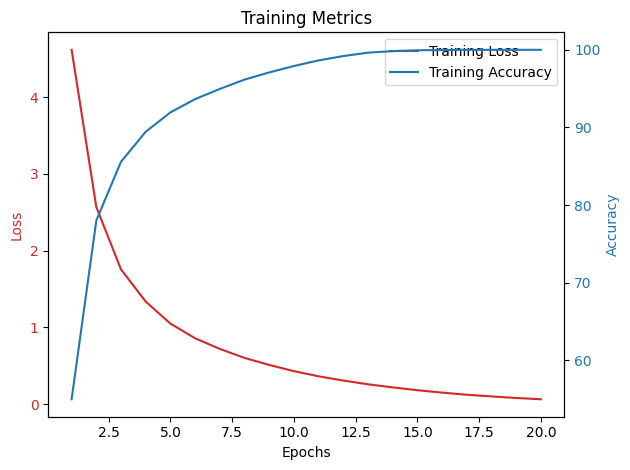

In [ ]:
plot_training_metrics(epoch_losses, epoch_accuracies)

<h2>Define a function to test the data</h2>


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch
from tqdm import tqdm
def test_loop(model, dataloader, loss_fun, device, tokenizer):
    model.eval()
    model.to(device)
    losses = []

    # Initialize ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lists to store ROUGE and BLEU scores
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    bleu_scores = []

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)

    with torch.no_grad():
        for batch, (x, y) in loop:
            # Put on device
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(x, y)

            # Reshape tensors
            batch_size, seq_len, vocab_size = y_pred.shape
            y_pred = y_pred.contiguous().view(-1, vocab_size)
            y = y.contiguous().view(-1)

            # Calculate test loss
            loss = loss_fun(y_pred, y)
            losses.append(loss.item())

            # Get predicted token indices
            pred_indices = torch.argmax(y_pred, dim=-1).view(batch_size, seq_len)

            # Decode predictions and references
            pred_summaries = decode_batch(x, pred_indices, tokenizer)
            ref_summaries = decode_batch(x, y.view(batch_size, seq_len), tokenizer)

            # Calculate ROUGE and BLEU scores
            for pred, ref in zip(pred_summaries, ref_summaries):
                # ROUGE scores
                scores = rouge_scorer_obj.score(ref, pred)
                for key in rouge_scores:
                    rouge_scores[key].append(scores[key].fmeasure)

                # BLEU score
                bleu_scores.append(sentence_bleu([ref.split()], pred.split()))

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    # Calculate final metrics
    avg_loss = sum(losses) / len(losses)
    final_rouge_scores = {key: sum(scores) / len(scores) for key, scores in rouge_scores.items()}
    final_bleu_score = sum(bleu_scores) / len(bleu_scores)

    print(f"Average Test Loss: {avg_loss:.4f}")
    print(f"ROUGE Scores:")
    for key, value in final_rouge_scores.items():
        print(f"  {key}: {value:.4f}")
    print(f"Average BLEU Score: {final_bleu_score:.4f}")

    return avg_loss, final_rouge_scores, final_bleu_score

def decode_batch(x, token_ids, tokenizer):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()

    decoded = []
    for input_seq, pred_seq in zip(x, token_ids):
        # Convert input sequence to string
        input_text = ' '.join(map(str, input_seq))
        # Tokenize the input sequence
        tokens = [token.text for token in tokenizer(input_text)]
        # Map predicted indices to tokens
        pred_tokens = [tokens[i] if i < len(tokens) else '' for i in pred_seq]
        # Join tokens into a string
        decoded.append(' '.join(pred_tokens))

    return decoded

<h2>Calcualate the ROUGE and BLEU scores for Text Summarization task</h2>


In [ ]:
# Call the test_loop function
avg_loss, rouge_scores, bleu_score = test_loop(model, test_loader, loss_fun, device, tokenizer)

100%|██████████| 112/112 [00:05<00:00, 21.33it/s, loss=0.228] 

Average Test Loss: 0.5226
ROUGE Scores:
  rouge1: 0.9913
  rouge2: 0.9708
  rougeL: 0.9913
Average BLEU Score: 0.9814
